# Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from warnings import filterwarnings
filterwarnings('ignore')
seed = 42

# EDA

In [2]:
df = pd.read_csv('Dataset_B_hotel.csv')

In [3]:
df.head(10)

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0.0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0.0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0.0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0.0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0.0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled
5,INN00006,2,0,0,2,Meal Plan 2,0.0,Room_Type 1,346,2018,9,13,Online,0,0,0,115.00,1,Canceled
6,INN00007,2,0,1,3,Meal Plan 1,0.0,Room_Type 1,34,2017,10,15,Online,0,0,0,NaN,1,Not_Canceled
7,INN00008,2,0,1,3,Meal Plan 1,0.0,Room_Type 4,83,2018,12,26,Online,0,0,0,105.61,1,Not_Canceled
8,INN00009,3,0,0,4,Meal Plan 1,0.0,Room_Type 1,121,2018,7,6,Offline,0,0,0,96.90,1,Not_Canceled
9,INN00010,2,0,0,5,Meal Plan 1,0.0,Room_Type 4,44,2018,10,18,Online,0,0,0,133.44,3,Not_Canceled


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     35368 non-null  object 
 6   required_car_parking_space            35005 non-null  float64
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

Dari data diatas kita dapat menyimpulkan data yang akan kita pakai/kita drop.
Saya memutuskan untuk drop booking ID karena booking ID tidak ada pengaruh dan untuk variabel waktu kedatangan juga tidak akan berpengaruh pada kemungkinan booking tersebut akan di cancel/not cancelled.
dari data description juga kita mengetahui bahwa adalah required_car_parking_space sebuah data binary yang bisa digantikan ke object terlebih dahulu untuk menemukan categorical column yang cocok

In [5]:
df = df.drop('Booking_ID', axis = 1)
df = df.drop('arrival_year', axis = 1)
df = df.drop('arrival_month', axis = 1)
df = df.drop('arrival_date', axis = 1)
df['required_car_parking_space'] = df['required_car_parking_space'].astype(object)

In [6]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
num_cols = df.select_dtypes(exclude=['object']).columns.tolist()

In [7]:
unique = []
for i in cat_cols:
  unique.append(df[i].unique())
unique

[array(['Meal Plan 1', 'Not Selected', 'Meal Plan 2', nan, 'Meal Plan 3'],
       dtype=object),
 array([0.0, nan, 1.0], dtype=object),
 array(['Room_Type 1', 'Room_Type 4', 'Room_Type 2', 'Room_Type 6',
        'Room_Type 5', 'Room_Type 7', 'Room_Type 3'], dtype=object),
 array(['Offline', 'Online', 'Corporate', 'Aviation', 'Complementary'],
       dtype=object),
 array(['Not_Canceled', 'Canceled'], dtype=object)]

Dari hasil unique object diatas kita dapat menyimpulkan bahwa semua kolom categorical tidak memiliki hirarki kecuali market_segment sehingga kita dapat menggunakan ordinal encoding dan sisanya dapat menggunakan one hot encoding dan untuk booking_status kita dapat menggunakan label encoding

In [8]:
df.duplicated().sum()

9627

In [9]:
df = df.drop_duplicates()

In [10]:
df.isna().sum()

no_of_adults                               0
no_of_children                             0
no_of_weekend_nights                       0
no_of_week_nights                          0
type_of_meal_plan                        879
required_car_parking_space              1190
room_type_reserved                         0
lead_time                                  0
market_segment_type                        0
repeated_guest                             0
no_of_previous_cancellations               0
no_of_previous_bookings_not_canceled       0
avg_price_per_room                      1493
no_of_special_requests                     0
booking_status                             0
dtype: int64

In [11]:
def box(df, cols, sub):
    plt.figure(figsize=(5 * sub, 5 * sub))
    for i, col in enumerate(cols):
        plt.subplot(sub, sub, i + 1)
        sns.boxplot(y=df[col])
        plt.title(col)
    plt.tight_layout()
    plt.show()

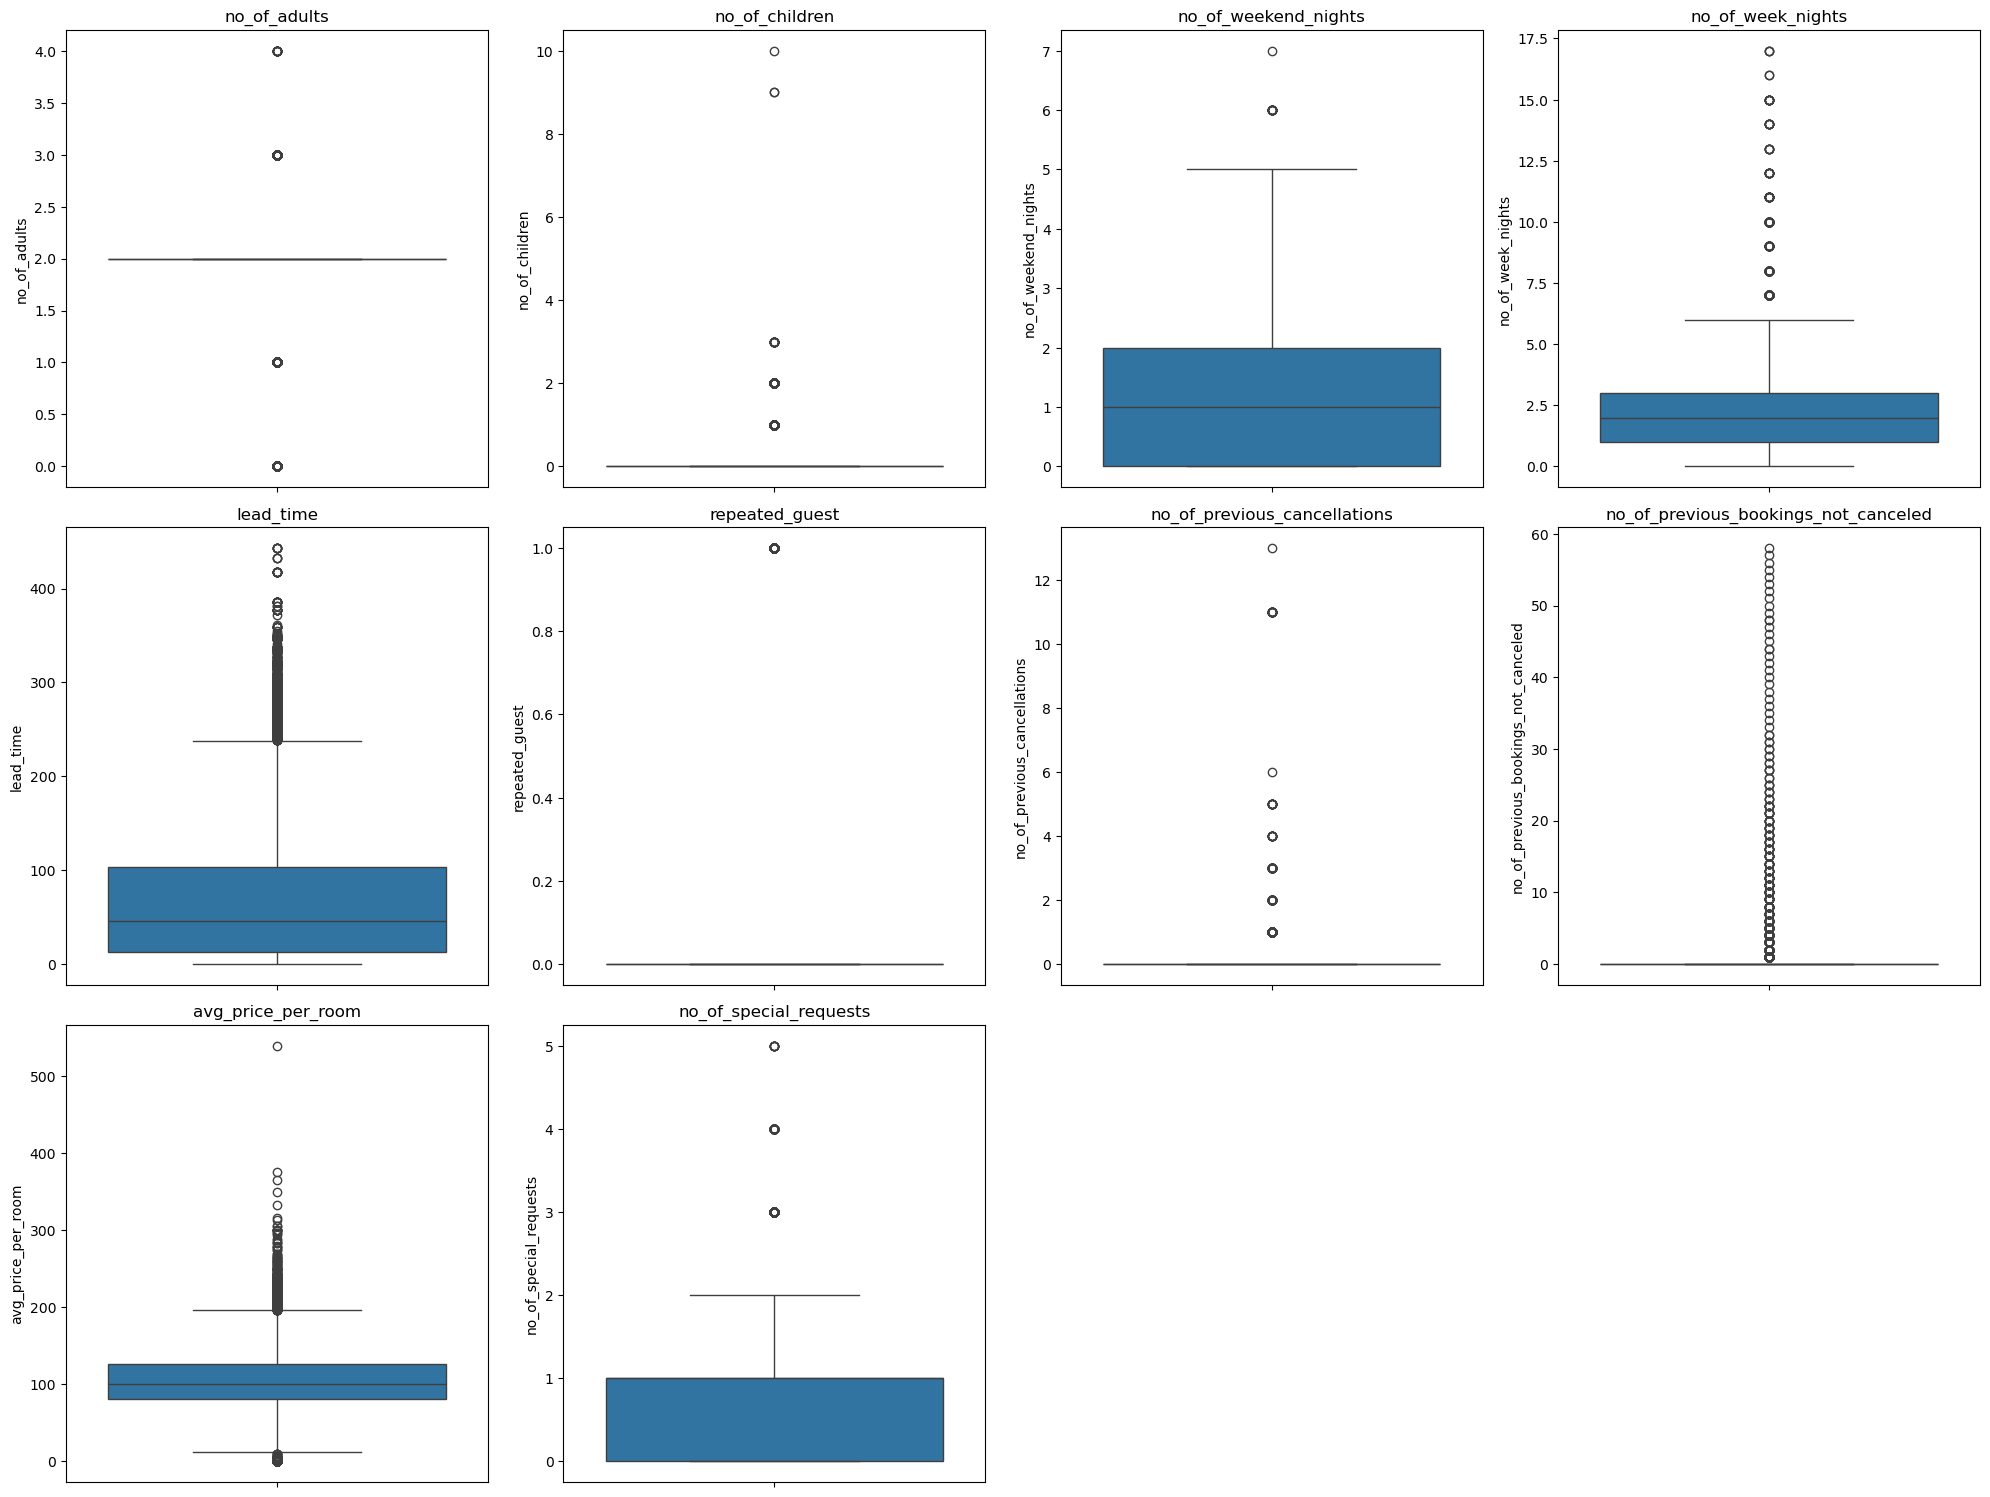

In [12]:
box(df, num_cols, 4)

Dari Graph diatas kita dapat melihat semua numerical columns memiliki outlier sehingga untuk nan values dapat diisi dengan median khususnya untuk avg price per room. Untuk kolom seperti required_car_parking_space bersifat binary sehingga bisa dibilang object maka itu saya aku melakukan imputasi menggunakan mode nilainya yaitu 0 karena 1 adalah outlier

In [13]:
df['avg_price_per_room'] = df['avg_price_per_room'].fillna(df['avg_price_per_room'].median())
df['required_car_parking_space'] = df['required_car_parking_space'].fillna(df['required_car_parking_space'].mode()[0])
df['type_of_meal_plan'] = df['type_of_meal_plan'].fillna(df['type_of_meal_plan'].mode()[0])

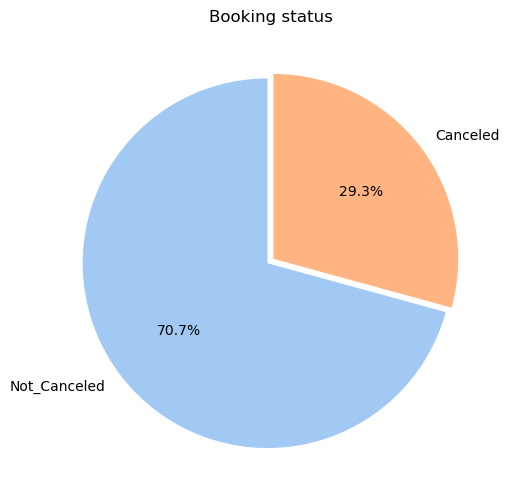

In [14]:
data = df['booking_status'].value_counts()
label = data.index

colors = sns.color_palette('pastel', len(label))

plt.figure(figsize = (8,6))
plt.pie(data, labels = label, autopct = '%1.1f%%',
        explode = [0.02] * len(label),
        startangle = 90,
        colors = colors)
plt.title('Booking status')
plt.show()

Dari graph diatas kita dapat melihat bahwa distribusi target variabel tidak seimbang sehingga menyebabkan model memiliki bias, maka itu untuk evaluation metric F1-score akan memiliki kepercayaan yang lebih tinggi dibanding dengan accuracy

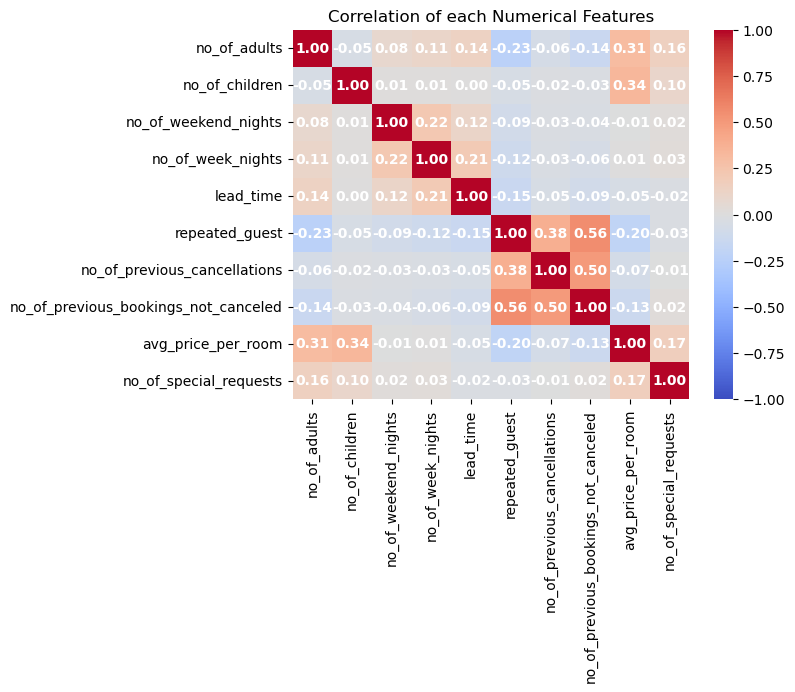

In [15]:
correlation = df[num_cols].corr(method = 'pearson')
sns.heatmap(correlation, annot = True,
            cmap='coolwarm',
            fmt = '.2f',center = 0, vmin = -1,
            annot_kws = {'size': 10, 'weight':'bold', 'color':'white'})
plt.title('Correlation of each Numerical Features')
plt.show()

# Feature Engineering

## Encoding

In [16]:
df['market_segment_type'] = df['market_segment_type'].map({'Complementary': 0, 'Offline': 1, 'Online': 2, 'Aviation': 3, 'Corporate': 4})
df['booking_status'] = df['booking_status'].map({'Not_Canceled': 0, 'Canceled': 1})

ohe_col = ['type_of_meal_plan', 'room_type_reserved']
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded = ohe.fit_transform(df[ohe_col])
encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(ohe_col), index = df.index) 
df = df.drop(ohe_col, axis=1)
df = pd.concat([df, encoded_df], axis=1)

df['required_car_parking_space'] = df['required_car_parking_space'].astype(int)

## Splitting the Data

In [17]:
X = df.drop('booking_status', axis = 1)
y = df['booking_status']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)

## Scaling

In [19]:
robustScale = RobustScaler()
X_train_scaled = robustScale.fit_transform(X_train)
X_test_scaled = robustScale.transform(X_test)

# Random Forest

In [20]:
RF = RandomForestClassifier(random_state = seed)
RF.fit(X_train, y_train)

y_pred_train = RF.predict(X_train)
y_pred_test = RF.predict(X_test)

In [21]:
print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

print(f"Accuracy Score Train-set: {accuracy_score(y_train, y_pred_train):.4f}\n")
print(f"Accuracy Score Test-set: {accuracy_score(y_test, y_pred_test):.4f}\n")

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     15040
           1       0.99      0.99      0.99      6278

    accuracy                           0.99     21318
   macro avg       0.99      0.99      0.99     21318
weighted avg       0.99      0.99      0.99     21318

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      3811
           1       0.74      0.65      0.70      1519

    accuracy                           0.84      5330
   macro avg       0.81      0.78      0.79      5330
weighted avg       0.83      0.84      0.83      5330

Accuracy Score Train-set: 0.9934

Accuracy Score Test-set: 0.8368



In [22]:
RF_paramgrid = {
    'n_estimators': [20, 40, 60, 80, 100, 120],
    'max_depth': [None, 2, 3, 5, 10],
    'max_features': ['sqrt', 'log2'],
}


RF_grid = GridSearchCV(RF,
                       RF_paramgrid,
                       cv=5,
                       scoring='accuracy')
RF_grid.fit(X_train, y_train)
print("Best parameters for Random Forest:\n", RF_grid.best_params_)
print('Best Score Random Forest:', RF_grid.best_score_)

Best parameters for Random Forest:
 {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 40}
Best Score Random Forest: 0.8404635484264222


In [29]:
best_RF = RandomForestClassifier(random_state = seed, class_weight = 'balanced', n_estimators = 40, max_depth = 10, max_features = 'sqrt')
best_RF.fit(X_train, y_train)

y_pred_train = best_RF.predict(X_train)
y_pred_test = best_RF.predict(X_test)

print('Classification Report Train-set:\n', classification_report(y_train, y_pred_train))
print('Classification Report Test-set:\n', classification_report(y_test, y_pred_test))
print(f"Accuracy Score Train-set: {accuracy_score(y_train, y_pred_train):.4f}\n")
print(f"Accuracy Score Test-set: {accuracy_score(y_test, y_pred_test):.4f}")

Classification Report Train-set:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88     15040
           1       0.70      0.76      0.73      6278

    accuracy                           0.83     21318
   macro avg       0.80      0.81      0.81     21318
weighted avg       0.84      0.83      0.84     21318

Classification Report Test-set:
               precision    recall  f1-score   support

           0       0.89      0.86      0.88      3811
           1       0.68      0.73      0.70      1519

    accuracy                           0.82      5330
   macro avg       0.78      0.80      0.79      5330
weighted avg       0.83      0.82      0.83      5330

Accuracy Score Train-set: 0.8343

Accuracy Score Test-set: 0.8242


# XGBoost

In [24]:
xgb = XGBClassifier(random_state = seed)
xgb.fit(X_train, y_train)

y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

In [25]:
print('Classification Report Train-set:\n', classification_report(y_train, y_pred_train))
print('Classification Report Test-set:\n', classification_report(y_test, y_pred_test))
print(f"Accuracy Score Test-set: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Accuracy Score Test-set: {accuracy_score(y_test, y_pred_test):.4f}")

Classification Report Train-set:
               precision    recall  f1-score   support

           0       0.89      0.94      0.92     15040
           1       0.84      0.73      0.78      6278

    accuracy                           0.88     21318
   macro avg       0.87      0.84      0.85     21318
weighted avg       0.88      0.88      0.88     21318

Classification Report Test-set:
               precision    recall  f1-score   support

           0       0.87      0.92      0.90      3811
           1       0.77      0.66      0.71      1519

    accuracy                           0.85      5330
   macro avg       0.82      0.79      0.80      5330
weighted avg       0.84      0.85      0.84      5330

Accuracy Score Test-set: 0.8796
Accuracy Score Test-set: 0.8477


In [26]:
xg_params = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [None, 1, 2, 3],
}

xg_grid = GridSearchCV(xgb, xg_params, cv=5, scoring='accuracy')

xg_grid.fit(X_train, y_train)

print("Best parameters for XGBoost:\n", xg_grid.best_params_)
print('Best Score XGBoost:', xg_grid.best_score_)


Best parameters for XGBoost:
 {'learning_rate': 0.05, 'max_depth': None, 'n_estimators': 200}
Best Score XGBoost: 0.8457639450941145


In [30]:
best_xgb = XGBClassifier(random_state = seed, n_estimators = 200, learning_rate = 0.05, max_depth = None)
best_xgb.fit(X_train, y_train)

y_pred_train = best_xgb.predict(X_train)
y_pred_test = best_xgb.predict(X_test)

print('Classification Report Train-set:\n', classification_report(y_train, y_pred_train))
print('Classification Report Test-set:\n', classification_report(y_test, y_pred_test))
print(f"Accuracy Score Train-set: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Accuracy Score Test-set: {accuracy_score(y_test, y_pred_test):.4f}")

Classification Report Train-set:
               precision    recall  f1-score   support

           0       0.87      0.93      0.90     15040
           1       0.80      0.68      0.73      6278

    accuracy                           0.86     21318
   macro avg       0.84      0.80      0.82     21318
weighted avg       0.85      0.86      0.85     21318

Classification Report Test-set:
               precision    recall  f1-score   support

           0       0.87      0.93      0.90      3811
           1       0.78      0.65      0.71      1519

    accuracy                           0.85      5330
   macro avg       0.83      0.79      0.80      5330
weighted avg       0.84      0.85      0.84      5330

Accuracy Score Train-set: 0.8557
Accuracy Score Test-set: 0.8488


# Kesimpulan
Dari kedua model model XGBoost memiliki prediksi yang lebih baik dan modelnya tidak overfit seperti Random Forest sehingga jika ada data baru maka XGBoost akan melakukan prediksi dengan lebih baik